# Bayesian Hierarchical Clustering in Python
### STA 663 Final Project
*Shaoji Li & Xichu Liu*

Github Repo: https://github.com/lishaoji/LLBHC

## Abstract
In this project, we tend to implement the Bayesian Hierarchical Clustering algorithm, presented by Dr. Katherine Heller and Dr. Zoubin Ghahramani back in 2005. The algorithm, similar to any agglomerative clustering with distance metrics, is a one-pass, bottom-up method initializing each point in its own cluster and then iteratively merges pairs of cluster by measuring the marginal likelihood and determining whether to proceed. In Python, we first break down the algorithm into multiple parts, then implement each part individually, and eventually resemble the whole process. Using both synthetic and real-world data, we test our implementation's correctness and efficiency, where optimization methods are applied. The goal is to efficiently implement the algorithm in its original setting, where Dirichet Process is its generative model and the dataset follows a multinomial distribution. At the end, we discuss the applications of our implementation, as well as the Bayesian Hierarchical Clustering algorithm in general.

## Introduction
Hierarchical Clustering is a popular clustering method in unsupervised learning. It aims to separate data points with different features into single or multiple groups, and its result should be intuitive and understandable to human knowledge. The traditional method for hierarchical clustering is a bottom-up agglomerative algorithm, where it starts with each data point as its own cluster and iteratively merges the two closet clusters together until all the data belongs to a single cluster. A certain kind of distance metric determines which pair of clusters should be combined, and popular distance metrics include average linkage, single linkage, etc. For instance, average linkage is equivalent to merging the clusters by calculating the average Euclidean distance among all points and then seeking the ones with maximum values. 

However, there are some limitation to the traditional hierarchical clustering algorithm. First, the algorithm requires a manual input of cutoff point to stop the merging process. In other words, whoever uses the program has to choose how many clusters she or he wants, and once the specified threshold is reached, the algorithm stops. This characteristic causes a serious problem when the user has no prior knowledge of the dataset, and even if she or he does, it is still very difficult to come up with a right and accurate distance metric which aligns with the dataset, especially in structured data, such as image. Second, as the algorithm lacks of a probabilist model, the user can not perform any statistical inference or prediction based on the clustering results, while choosing a way to measure the goodness of the clustering becomes impossible. 

Bayesian Hierarchical Clustering algorithm is very similar to the traditional one in many ways, such as bottom-up and hierarchical with tree structure, but it uses marginal likelihood, instead of distance metric, to decide which clusters to merge. More specifically, the algorithm seeks the probability that all the data in a potential merge comes from the same mixture component, and compares to the hypotheses at lower levels of the tree. Dirichelet process mixture model serves as the generative model here, while the data should follow a discreet multinomial distribution. Besides, instead of calculating all the marginal likelihood for all tree partitions, the algorithm only calculate the tree-consistent ones, which reduces the computational burden in the Bayesian setting. Overall, the Bayesian Hierarchical Clustering has three major advantages: first, it provides a probabilistic model for merging, which can be used in explaining the clusters; second, it does not require a rigid choice of distance metric, which can be hard to choose; and, it is relatively computationally efficient, as the algorithm performs only in a tree-consistent structure.

## Theoretical Background

#### Dirichlet Process Mixtures
This sections follows Rasmussen(2000). For each of n data points being modeled by a finite mixture, we can associate cluster indicator variables, $c_1, c_2,... , c_n$, which can take on values $c_i \in \{1, ..., C\}$, where $C$ is the number of mixture components. The joint distribution of the indicator is multinomial with parameter vector $\textbf{p} = (p_1...p_C)$:
$$
p(c_1...c_n) = \prod_{j=1}^C p_j^{n_j}, \ \ \ n_j = \sum_{i=1}^n \delta(c_i,j)
$$

$n_j$ is the number of data points assigned to class j. If we place a symmetric Dirichlet prior on \textbf{p} with concentration parameters $\frac{\alpha}{C}$:
$$
p(p_1...p_C \mid \alpha) = \frac{\Gamma(\alpha)}{\Gamma(\alpha/C)^C} \prod_{j=1}^C p_j^{\alpha/C-1}
$$

by marginalizing \textbf{p} out, we get:

\begin{align*}
p(c_1...c_n \mid \alpha) &= \int p(c_1...c_n \mid p_1...p_C)dp_1...p_C \\
						 &= \frac{\Gamma(\alpha)}{\Gamma(n+\alpha)} \prod_{j=1}^C \frac{\Gamma(n_j+\alpha/C}{\Gamma(\alpha/C)}
\end{align*}

Then the conditional probability of each $c_i$ is:
$$
p(c_i = j \mid \textbf{c}_{-i},\alpha) = \frac{n_{-i,j}+\alpha/C}{n-1+\alpha}
$$

where $n_{-i,j}$ is the number of data points, excluding point i, assigned to class j. Finally, taking the infinite limit ($C$ -> $\inf$), we get:
$$
p(c_i = j \mid \textbf{c}_{-i},\alpha) = \frac{n_{-i,j}}{n-1+\alpha}, 
$$
$$
p(c_i \neq c_{i'}, \forall i' \neq i \mid \textbf{c}_{-i},\alpha) = \frac{\alpha}{n-1+\alpha}
$$

The second probability is the prior probability that point i belongs to a new class that no other points belong to.

#### Marginal Likelihood for Single Component

Within this implementation, the prior follows Dirichlet, while dataset follows multinomial.

If we have multinomial data, we then need a Dirichlet model. The posterior probability is shown below:

$$
p(D \mid H_1) = \prod_{i=1}^N \binom {M_i}{x_1^{(i)}...x_k^{(i)}}  \times \frac{\Gamma(\sum_{d=1}^k \alpha_d) \prod_{d=1}^k \Gamma(\alpha_d+m_d)}{\Gamma(M+\sum_{d=1}^k \alpha_d) \prod_{d=1}^k \Gamma(\alpha_d)}
$$

where $k$ is the total number of dimensions (columns), $N$ is the number of data points in the dataset, $M = \sum_{i=1}^N M_i$, $M_i = \sum_{j=1}^k x_j^{(i)}$, $m_d = \sum_{i=1}^N x_d^{(i)}$, $\textbf{$X$}$ is the dataset, and \textbf{$\alpha$} is a hyperparameter for the Dirichlet prior.

## Algorithm Introduction
The Bayesian Hierarchical clustering algorithm is similar to traditional agglomerative clustering in a way that it is one-pass, bottom-up method which initializes each data point in its own cluster and then iteratively merges pairs of clusters. The main difference is that, different from traditional clustering with distance metrics, Bayesian Hierarchical clustering uses statistical hypothesis test for the process. 

In each merge, two hypotheses are performed: whether all the data in the potential merge were generated independently and identically from the same probabilistic model and whether the data has two or more clusters in it. For the first test, we calculate its probability by applying Dirichlet prior to the multinomial distributed dataset, whose posterior formula is elaborated in the previous section. For the second test, as we only consider the partitions which are tree consistent, its probability is simply the product of the probabilities of its children nodes. By combining the probabilities of both tests, weighted by the prior that all points belong to one cluster, we obtain the marginal probability of the data. Eventually using Bayes rule, we can achieve the posterior probability of the merged hypothesis. If the value is above a certain amount which is usually 0.5 but can also be specified if necessary, then the two clusters should be merged into one; otherwise, we proceed to check other clusters. In next iteration, any previously merged clusters are treated as one cluster. In two cases, we stop the process: either within an iteration we fail to find any pair of clusters which should be merged, or all the data points are grouped into only one cluster.

## Algorithm Implementation
In order to accommodate the tree structure in the algorithm, we construct an object, called "node", to facilitate our objectives. Each node has two children nodes, both of which can be none if the node is an end node. The node also contains its associated datasets and the index number of cluster. Besides, the node keeps track of the number of all nodes, both internal and end, at all levels, where we use recursion to achieve this goal. Basically, this node object is the key component of the implementation and will be used enormous times throughout the program. 

To complete the implementation, we break it down into multiple parts, each of which contains only one key component as a function, and at the end, we integrate all individual functions into the general Bayesian Hierarchical Clustering function, called "bhc", which is the destination function with one requited parameter--dataset--and two non-essential parameters--alpha with default value 1 and probability threshold with default 0.5--as input. The output contains two node lists: the first one returns all unique resulting clusters, while the second gives the index number of cluster for all original data points.

The detailed implementations can be seen below.

In [1]:
%matplotlib inline

In [2]:
# require necessary packages
from scipy import special
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, vectorize, float64, int64
import seaborn as sns
import pandas as pd

In [3]:
sns.set_context('notebook', font_scale=1.5)

In [4]:
class node():
    """
    The class for node.
    Initialization requires two child branches, which may be None for end node, 
    the data points, and the index number of cluter.
    When initialized, the node also keeps track of the number of total nodes,
    both internal and end, within its structure as n.
    
    For example:
    new_node = node(None, None, np.repeat(1,4), 1)
    """
    
    # initialization 
    def __init__(self, left, right, data, cnum):
        # set up the left and right branches
        self.l = left
        self.r = right
        
        # track of number of total nodes using recursion
        if(left == None and right == None):
            self.n = 1
        else:
            self.n = left.n + right.n
            
        # save data points and number of cluster
        self.data = data
        self.cluster = cnum

In [5]:
@jit(float64(float64[:,:], int64[:]))

def p_hyp1(dataset, a):
    """
    Function to calculate the posterior probability.
    The input requires data, which is either a vector
    or a 2D numpy array, and an alpha value, which is
    a double
    """
    
    # extract the number of features and the total number of data
    
    # If the data is a vector, do the following
    if (len(dataset.shape) == 1):
        N = 1
        k = dataset.shape[0]
        # part I
        p1 = 1
        comp = special.gamma(np.sum(dataset)+1) / np.prod(special.gamma(dataset+1))
        p1 = p1 * comp
        
        # part II
        # iterate to calculate the probability
        p2 = p1 * special.gamma(np.sum(a)) / special.gamma(np.sum(dataset) + np.sum(a))
        for j in range(k):
            comp = special.gamma(a[j] + np.sum(dataset[j])) / special.gamma(a[j])
            p2 = p2 * comp
    # if the data is not vector, do the following
    else:
        N = dataset.shape[0]
        k = dataset.shape[1]
    
        # part I
        p1 = 1
        for i in range(N):
            comp = special.gamma(np.sum(dataset[i, :])+1) / np.prod(special.gamma(dataset[i, :]+1))
            p1 = p1 * comp
        
        # part II
        # iterate to calculate the probability
        p2 = p1 * special.gamma(np.sum(a)) / special.gamma(np.sum(dataset) + np.sum(a))
        for j in range(k):
            comp = special.gamma(a[j] + np.sum(dataset[:, j])) / special.gamma(a[j])
            p2 = p2 * comp

    return p2

In [6]:
def get_d(node, a):
    """
    Recursive function to calculate the 'd' value for each node
    
    """
    if node.l == None and node.r == None:
        return a
    else:
        return a*special.gamma(node.n) + get_d(node.l, a)*get_d(node.r, a)

In [7]:
def get_pi(node, a):
    """
    The function to calculate the weight for each node (pi_k).
    It uses d and the gamma function.
    The inputs are a node object and a double
    """
    dk = get_d(node, a)
    pi_k = a*special.gamma(node.n)/dk
    return pi_k

In [8]:
def get_dk(node, a):
    """
    The Recursive function to calculate the posterior probability for
    each node given a subtree (Ti).
    The inputs are a node and a double
    """
    post = p_hyp1(node.data, np.repeat(a, node.data.shape[1]))
    pi = get_pi(node, a)
    if node.l == None and node.r == None:
        return  pi * post
    else:
        return  pi * post + (1-pi) * get_dk(node.l, a) * get_dk(node.r, a)

In [9]:
def bhc(data, a=1, r_thres=0.5):
    """
    The Baysian Hierarchical Clustering algorithm.
    It is described in the paper collaborated by
    Dr. Katherine Heller and Dr. Zoubin Ghahramani
    in 2005.
    """
    
    # Initialize a node_list tracking the nodes to be merged
    # and a node_list_copy to track the cluster number of each
    # node. The initial value of those two lists are each data
    # points with its own cluster number.
    node_list = []
    node_list_copy = []
    for i in range(data.shape[0]):
        node_list.append(node(None, None, np.array([data[i,:]]), i))
        node_list_copy.append(node(None, None, np.array([data[i,:]]), i))
    
    # Cluster number, default value equals the number of data points
    c = data.shape[0]
    
    # Iterate to merge nodes. Note that BHC is a greedy algorithm, which means
    # If no tow nodes can be merged, the loop stops automatically
    while c > 1:
        # Indicate whether to break the while loop
        flag = False
        
        for i in range(len(node_list)):
            for j in range(i+1, len(node_list)):
                # Create a new data by row-binding the datasets in the two nodes
                newdata = np.concatenate((node_list[i].data, node_list[j].data), axis = 0)
                
                # Create a new node based on the new data
                # Set the cluster number of the new node to
                # the minimum of the two nodes combined
                node_new = node(node_list[i], node_list[j], newdata, 
                                min(node_list[i].cluster,node_list[j].cluster))
                
                # Calculate the probability of the hypothesis being true
                pi_k = get_pi(node_new, a)
                
                # Calculate the posterior probability of data given hypothesis
                p_hyp = p_hyp1(node_new.data, np.repeat(a, data.shape[1]))
                
                # Calculate the posterior probability of data given subtree
                p_dk = get_dk(node_new, a)
                
                # Calculate the probability of the merged hypothesis
                rk = pi_k * p_hyp / p_dk
                
                # If the probability of the merged hypothesis is greater
                # than the threshold we set, merge the two nodes, reset
                # their cluster number in node_list_copy and remove the
                # two nodes from nodes_list.
                
                # Note that since it's a greedy algorithm, we break the
                # double for loop if the nodes are merged and continue
                # on finding the next two nodes to merge.
                if rk >= r_thres:
                    for k in range(len(node_list_copy)):
                        entry = node_list_copy[k].cluster
                        if entry == node_list[i].cluster or entry == node_list[j].cluster:
                            node_list_copy[k].cluster = min(node_list[i].cluster,node_list[j].cluster)
                    node_list =  node_list[:i] + node_list[(i+1):j] + node_list[(j+1):]
                    node_list = [node_new] + node_list
                    
                    c = c - 1
                    flag = True
                    break
            if flag == True:
                break
        
        if flag == False:
            c = 1        

    return node_list, node_list_copy

## Algorithm Testing
We use both simulated data and real data to test our algorithm.
### 1. Synthetic Data
**Data Generation**

In [10]:
## simulated test data
d1 = np.random.randint(0,2, size=(7,2))
d2 = np.random.randint(9,11, size=(7,2))
d3 = np.random.randint(18,20, size=(7,2))
sdata = np.concatenate((d1,d2,d3),axis=0)
sdata

array([[ 1,  0],
       [ 0,  1],
       [ 0,  1],
       [ 0,  1],
       [ 1,  0],
       [ 0,  1],
       [ 1,  1],
       [10,  9],
       [ 9,  9],
       [ 9, 10],
       [10,  9],
       [10, 10],
       [ 9,  9],
       [10,  9],
       [19, 18],
       [19, 18],
       [18, 19],
       [18, 19],
       [19, 19],
       [18, 19],
       [18, 19]])

**Test Result**

*Threshold = 0, $\alpha$ = 2*

In [11]:
# test when alpha = 2, r_thresh=0
nodes_sim, nodes_cluster_sim = bhc(sdata, a=2, r_thres=0)

C:\Users\jason\Anaconda3\lib\site-packages\ipykernel\__main__.py:43: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\jason\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


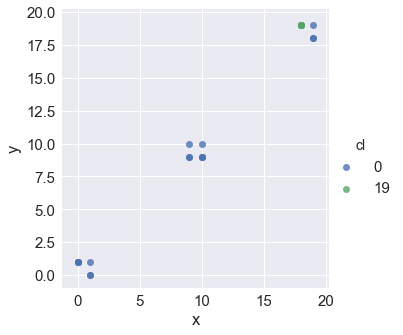

In [12]:
# 0
cl = np.array([node.cluster for node in nodes_cluster_sim])
df = {'x' : sdata[:,0], 'y' : sdata[:,1], 'cl' : cl}
df = pd.DataFrame(df)
sns.lmplot('x', 'y',
           data=df,
           fit_reg = False,
           hue='cl')

*Threshold = 0.5, $\alpha$ = 2*

In [13]:
nodes_sim, nodes_cluster_sim = bhc(sdata, a=2, r_thres=0.5)

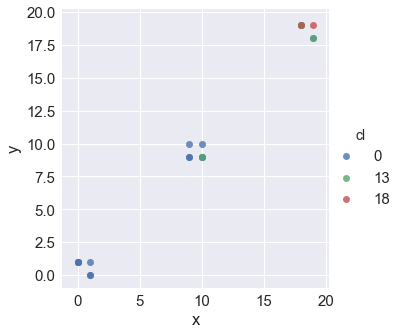

In [14]:
# 0.5
cl = np.array([node.cluster for node in nodes_cluster_sim])
df = {'x' : sdata[:,0], 'y' : sdata[:,1], 'cl' : cl}
df = pd.DataFrame(df)
sns.lmplot('x', 'y',
           data=df,
           fit_reg = False,
           hue='cl')

*Threshold = 0.9, $\alpha$ = 2*

In [15]:
nodes_sim, nodes_cluster_sim = bhc(sdata, a=2, r_thres=0.9)

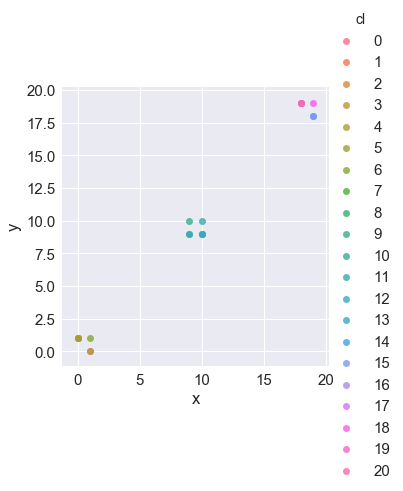

In [16]:
# 0.9
cl = np.array([node.cluster for node in nodes_cluster_sim])
df = {'x' : sdata[:,0], 'y' : sdata[:,1], 'cl' : cl}
df = pd.DataFrame(df)
sns.lmplot('x', 'y',
           data=df,
           fit_reg = False,
           hue='cl')

**Discussion**

The first graph is the cluster result when we set the threshold of $r_k$ to be 0.1, where we can see that almost all data points are combined into one cluster.The second graph shows when the threshold is 0.5, we have three distinct clusters, which is consistent with our simulation process. Note that unlike k-means or other clustering methods, Bayesian Hierarchical Clustering does not perfectly shatter the data. This is because we use Dirichlet process as a mixture. However, it still offers a reasonable representation for clustering.The third graph shows when the threshold is high (0.9 etc.), every data point belongs to its own cluster.

### 2. Real Data
We use the wine quality data, "wine-quality-red" from UCI machine learning repository. To avoid complex computation, we only used a small amount of data (10 rows and 5 features) for testing.

**Data Generation**

In [17]:
with open("wine.csv") as f:
    next(f)
    text = f.read() 

data = []
lines  = text.split('\n')
for line in lines[:-1]:
    arr = line.split(';')
    fl = [int(np.round(float(x))) for x in arr]
    data.append(fl)

data = np.array(data)

In [18]:
# test data from wine.csv
tdata = data[:10,:5]
tdata

array([[ 7,  1,  0,  2,  0],
       [ 8,  1,  0,  3,  0],
       [ 8,  1,  0,  2,  0],
       [11,  0,  1,  2,  0],
       [ 7,  1,  0,  2,  0],
       [ 7,  1,  0,  2,  0],
       [ 8,  1,  0,  2,  0],
       [ 7,  1,  0,  1,  0],
       [ 8,  1,  0,  2,  0],
       [ 8,  0,  0,  6,  0]])

**Test Result**

We test two boundary cases: the probability thresholds for merge are 0 and 1 respectively. The results align with our assumptions that for 0, all data points belong to one cluster, while for 1, each cluster only contains one original data point.

In [19]:
# test when the threshold for rk is 0 and alpha = 1
node_list, node_list_cluster = bhc(tdata, a=1, r_thres=0)

In [20]:
[node.cluster for node in node_list_cluster]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [21]:
[node.data for node in node_list]

[array([[ 7,  1,  0,  2,  0],
        [ 8,  1,  0,  3,  0],
        [ 8,  1,  0,  2,  0],
        [11,  0,  1,  2,  0],
        [ 7,  1,  0,  2,  0],
        [ 7,  1,  0,  2,  0],
        [ 8,  1,  0,  2,  0],
        [ 7,  1,  0,  1,  0],
        [ 8,  1,  0,  2,  0],
        [ 8,  0,  0,  6,  0]])]

In [22]:
# test when the threshold for rk is 1 and alpha = 1
nodes, nodes_cluster = bhc(tdata, a=1, r_thres=1)

In [23]:
[node.cluster for node in nodes_cluster]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [24]:
[node.data for node in nodes]

[array([[7, 1, 0, 2, 0]]),
 array([[8, 1, 0, 3, 0]]),
 array([[8, 1, 0, 2, 0]]),
 array([[11,  0,  1,  2,  0]]),
 array([[7, 1, 0, 2, 0]]),
 array([[7, 1, 0, 2, 0]]),
 array([[8, 1, 0, 2, 0]]),
 array([[7, 1, 0, 1, 0]]),
 array([[8, 1, 0, 2, 0]]),
 array([[8, 0, 0, 6, 0]])]

## Algorithm Diagnosis & Optimization
As Bayesian Hierarchical Clustering is a greedy algorithm which counts only tree-consistent partitions, it is much quicker and more efficient than the one with all partitions. Still, the number of iterations increases exponentially with the size of the dataset. In our case, 500 is the critical point, above which we see failure for most computers. Although the algorithm's speed does not heavily rely on the number of features, we do note that the range of each feature has a great influence over the program. Its reason is that as dataset is considered to follow a multinomial distribution, each feature input is treated as a distinct factor, and therefore having either too many factors or multiple too large factors can severely incapacitate the program. 

Due to the nature of our self-defined tree-node object, most of the optimization techniques become unavailable, such as vectorization and cython. However, we manage to apply jit to the first hypothesis probability part, which is used frequently in the implementation. Although the process will not speed up dramatically, we do notice that the overall performance of the implementation has been improved. 

Some runtime comparison can be seen below.

In [26]:
# Without jit
%timeit bhc(sdata, a=1, r_thres=0.5)

The slowest run took 5.54 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 191 ms per loop


In [28]:
# with jit
%timeit bhc(sdata, a=1, r_thres=0.5)

10 loops, best of 3: 111 ms per loop


## Conclusion
Through synthetic data, although the algorithm's performance certainly can be affected by the probability cutoff value, in general the algorithm can cluster the dataset relatively well, even with the default value. With respect to real-world data, due to the computational restraints and data entry type requirement which the algorithm intrinsically inherits, usually data cleaning and sampling is required. Once a suitable dataset becomes available, the algorithm does succeed in doing a quite impressive job to cluster it. Within each cluster, the purity score is high, meaning that the majority of the cluster shares the same label.

For our implementation, not only we implement the Bayesian Hierarchical Clustering algorithm in the Multinomial-Dirichelet setting, but also we leave extensive maneuver room for the users by offering options to various parameters, including both prior alpha and probability cutoff threshold, so we hope that it can suit advanced users' need. On the other hand, as most of the parameters have default settings, the algorithm can still perform by simply plugging the dataset, where no prior knowledge is required. Besides, as the model we implement is Multinomial-Dirichelt, the algorithm can also be extrapolated to the data with Bernoulli data entry without losing too much accuracy, as the algorithm can be applied to any dataset with discrete entry with caution. 

## References
Dr. Katherine Heller & Dr. Zoubin Ghaharami. (2005) Bayesian Hierarchical Clustering.  UCL

Rasmussen, C. E. (2000). The infinite Gaussian mixture model.
NIPS 12 (pp. 554–560).

Vaithyanathan, S., & Dom, B. (2000). Model-based hierarchical
clustering. UAI.

Blei, D., & Jordan, M. (2004). Variational methods for dirichlet
process mixture models (Technical Report 674). UC Berkeley

Banfield, J. D., & Raftery, A. E. (1993). Model-based Gaussian
and non-Gaussian clustering. Biometrics, 49, 803–821.

Richard S Savage, Katherine Heller, Yang Xu, Zoubin Ghahramani, William M Truman, Murray Grant, Katherine J Denby and David L WildEmail. (2009) RBHC: fast Bayesian hierarchical clustering for microarray data. BMC Bioinformatics

In [ ]:
!jupyter nbconvert --to pdf project.ipynb